# Credit Card Fraud Detection through Hybrid HDBScan and Isolation Forest 

In [1]:
## Logger configuration
from loguru import logger

logger.remove()

logger.add("logs/hdbscan.log",
           level = "DEBUG",
           format = "{time:HH:mm:ss} | {level} | {message}")

1

## Data Loading and Preparation

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

data  = pd.read_csv("../creditcard.csv")

sampled_df, _ = train_test_split(data, 
                                test_size = 0.90, 
                                stratify = data['Class'], 
                                random_state = 42)

df = sampled_df

df.shape

(28480, 31)

We only apply scaling to features that have not otherwise been scaled. In this case, We only need to scale the "Amount" column.

Then, we make a copy of our prepared dataframe (`df`) for use in clustering (`hdb_df`). Labels are stored for later use in clustering within `label_df`. 

Lastly, we remove the Class and Time column from `hdb_df`. 

In [3]:
from sklearn.preprocessing import StandardScaler

## Scale the "Amount" column
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

# Save labels for later 
label_df = pd.DataFrame({"Class": df["Class"]})

## Copy prepared df for clustering 
hdb_df = df.copy()
hdb_df.drop(columns = ["Class", "Time"], inplace = True)

## Define hdbscan training function

In [7]:
from sklearn.cluster import HDBSCAN
from time import time

def hdbscan_clustering(X, params):
    
    ## Set n_jobs to use all available cores
    params["n_jobs"] = -1
    
    ## Cluster it up
    start_time = time()                        # Record start time
    hbdscan = HDBSCAN(**params)                # Instantiate model with input parameters
    cluster_labels = hbdscan.fit_predict(X)    # Assign Cluster Labels 
    end_time = time()                          # Record End Time  
    
    ## Record model training time and parameters used 
    total_training_time_seconds = end_time - start_time
    minutes, seconds = divmod(total_training_time_seconds, 60)
    formatted_time = f"{int(minutes):02}:{int(seconds):02}"
    logger.info(f"HBDScan Model Trained | Train Time (Minutes): {formatted_time} | Parameters | {params} |")
    
    return cluster_labels

In [ ]:
params = {}
clusters = hdbscan_clustering(df, params)

## Do a weird grid search for clustering parameters

- [HBDScan Parameters Documentation](https://hdbscan.readthedocs.io/en/latest/parameter_selection.html)


In [ ]:

import itertools

def cluster_grid_search(X, param_grid, label_df):
    
    """
    Accepts X, a parameter grid, and a dataframe with class labels and conducts 
    a HDBScan model grid search. 
    
    Logs results in notebooks/hdbscan.log
    
    For each set of parameters, records:
    - the parameters
    - the % noise
    - Count of fraud in clusters, and 
    - Number of clusters   
    """
    
    def analyze_clusters(label_df, cluster_labels):
    
        """
        Accepts a dataframe with class labels, and labels from an HDBScan cluster prediction.
        Logs results as described above. 
        """
        
        ## Create eval_df for testing 
        eval_df = label_df.copy()
        eval_df["Cluster"] = cluster_labels
        
        ## Cluster / Class Distribution Table 
        distribution = eval_df.groupby('Cluster')['Class'].value_counts().unstack(fill_value=0)
        
        ## Assemble counts  
        cluster_count = eval_df["Cluster"].nunique()  
        total_noise_count = (eval_df["Cluster"] == -1).sum()
        total_fraud_count = (eval_df["Class"] == 1).sum()
        noise_fraud_count = distribution.loc[-1, 1]
        
        ## Results
        logger.info(f"# Clusters: {cluster_count} | Noise: {((total_noise_count / eval_df.shape[0]) * 100).round(2)}% | Fraud in cluster: {total_fraud_count - noise_fraud_count} | Fraud in noise: {noise_fraud_count}")
    
    
    
    # Extract parameters and generate all combinations 
    keys, values = zip(*param_grid.items())
    iter_param = [dict(zip(keys, combo)) for combo in itertools.product(*values)]
    
    
    # Execute Grid Search 
    combinations = len(iter_param)
    logger.info(f"Grid Search Initiated | Combinations to attempt: {combinations}")
    counter = 0
    
    for p in iter_param:
        logger.info(f"Search {counter} / {combinations}")
        clusters = hdbscan_clustering(X, p)
        analyze_clusters(label_df, clusters)
        counter += 1

In [10]:
## Run Grid Search        
param_grid = {
        'min_cluster_size': [5, 25, 50, 75, 100],
        'min_samples': [None, 5, 10],
        'cluster_selection_epsilon': [0.1, 1, 5],
    }

cluster_grid_search(df, param_grid, label_df)

## Select HBDScan Parameters

Considerations for selecting these parameters:
- Balance noise % and number of clusters
- Prioritize fraud in clusters 
- Conducting a sophisticated smell test (below)



In [16]:
param_list = [
    {'min_cluster_size': 50,
     'min_samples': 5,
     'cluster_selection_epsilon': 1},
    
    {'min_cluster_size': 100,
     'min_samples': 5,
     'cluster_selection_epsilon': 1},
    
    {'min_cluster_size': 75,
     'min_samples': 10,
     'cluster_selection_epsilon': 1},
    
    {'min_cluster_size': 75,
     'min_samples': 5,
     'cluster_selection_epsilon': 1},
    ]

test_param = param_list[0]

In [19]:
clusters = hdbscan_clustering(hdb_df, param_list[0])

In [45]:
clusters

array([-1, -1, -1, ..., -1, -1, -1])

## Cluster Analysis 

### Cluster Size Histogram 
[matplotlib hist documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html)

In [46]:
import matplotlib.pyplot as plt

def plot_cluster_histogram(label_df, cluster_labels, test_param, param_index):
    
    ## Create eval_df for testing 
    eval_df = label_df.copy()
    eval_df["Cluster"] = cluster_labels
    
    ## Cluster / Class Distribution Table 
    distribution = eval_df.groupby('Cluster')['Class'].value_counts().unstack(fill_value = 0)
    print(distribution)
    
    ## Math 
    ### Cluster Counts
    cluster_count = eval_df["Cluster"].nunique()  
    clusters_with_fraud = len(distribution[distribution[1] > 0]) - 1   # Minus one to not count fraud in noise 
    clusters_with_1_fraud = len(distribution[distribution[1] == 1])
    
    ### Noise percentage, amount of fraud in noise 
    total_noise_count = (eval_df["Cluster"] == -1).sum()
    noise_pct = ((total_noise_count / eval_df.shape[0]) * 100).round(2)
    noise_fraud_count = distribution.loc[-1, 1]
    
    ### Average cluster size 
    cluster_sizes = (eval_df["Cluster"].value_counts()).iloc[1:]    # Drop the noise 
    avg_cluster_size = cluster_sizes.mean().round()
    
    
    ## Plot Histogram 
    plt.figure(figsize = (10, 6))
    plt.tight_layout()
    
    ### Use 50 unit bins, set x limit to account for bin size and range
    bins = range(0, cluster_sizes.max() + 50, 50) 
    cluster_sizes.hist(bins=bins)
    plt.xlim(50, 800)
    
    ### Plot and axis labels  
    plt.title(f"HDBScan Cluster Size Histogram {param_index}")
    plt.xlabel('Cluster Population')
    plt.ylabel('Cluster Count')
    
    ### Parameter Text Box in Top Right 
    params_title = r"$\bf{Parameters}$" + "\n"
    params_text = "\n".join([f"{key}: {value}" for key, value in test_param.items()])

    plt.text(x = 1.05, 
            y = .95, 
            s = params_title + params_text, 
            ha = 'left',                     # Horizontal Alignment 
            va = 'top',                      # Vertical Alignment 
            transform = plt.gca().transAxes, 
            fontsize = 10) 
    
    ### Details Text Box in Middle Right 
    details_title = r"$\bf{Cluster\ Details}$" + "\n"
    details_text = f"Clusters: {cluster_count}\nAvg Cluster Size: {avg_cluster_size}\nNoise: {noise_pct}%\nClusters with Fraud: {clusters_with_fraud}\nClusters with >0 Fraud: {clusters_with_1_fraud}\nNoise count: {total_noise_count}\n{noise_fraud_count}"

    plt.text(x = 1.05, 
            y = .5, 
            s = details_title + details_text, 
            ha = 'left',                     # Horizontal Alignment 
            va = 'top',                      # Vertical Alignment 
            transform = plt.gca().transAxes, 
            fontsize = 10) 
    
    plt.savefig(f"../graphs/cluster_histograms/HDBScan Cluster Size Histogram {param_index}",
                bbox_inches='tight')
#     plt.show()

    ## Log Results 
#     logger.info(f"Clusters: {cluster_count} | Avg Cluster Size: {avg_cluster_size} | Noise: {noise_pct}% | Clusters with Fraud: {clusters_with_fraud} | Clusters with 1 Fraud: {clusters_with_1_fraud}")


Class        0   1
Cluster           
-1       14453  48
 0        1598   0
 1          89   0
 2          63   0
 3          64   0
...        ...  ..
 68         65   0
 69        232   0
 70         86   0
 71        170   0
 72         77   0

[74 rows x 2 columns]


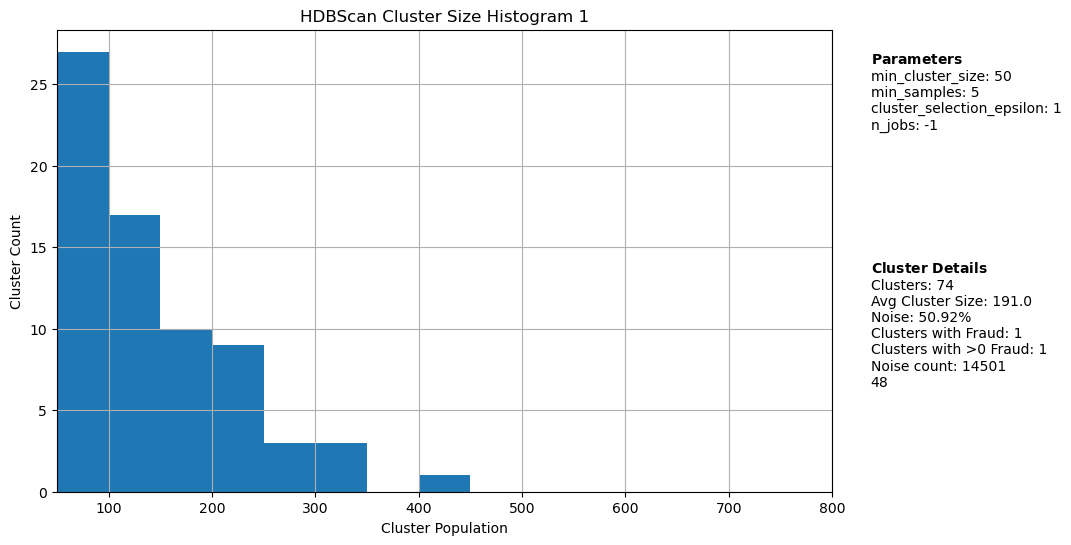

In [47]:
plot_cluster_histogram(label_df, clusters, test_param, param_index = 1)

In [ ]:
import umap
import umap.plot

def plot_umap_projection(data, labels, param_index):

    reducer = umap.UMAP()
    embedding = reducer.fit(data)
    
    umap.plot.points(embedding, 
                 labels = labels, 
                 theme = "fire", 
                 show_legend = False)
    
    plt.title(f"Fraud Data Cluster UMAP Projection {param_index}")
    plt.savefig(f"../graphs/cluster_umaps/UMAP Cluster Projection {param_index}",
            bbox_inches='tight')
    

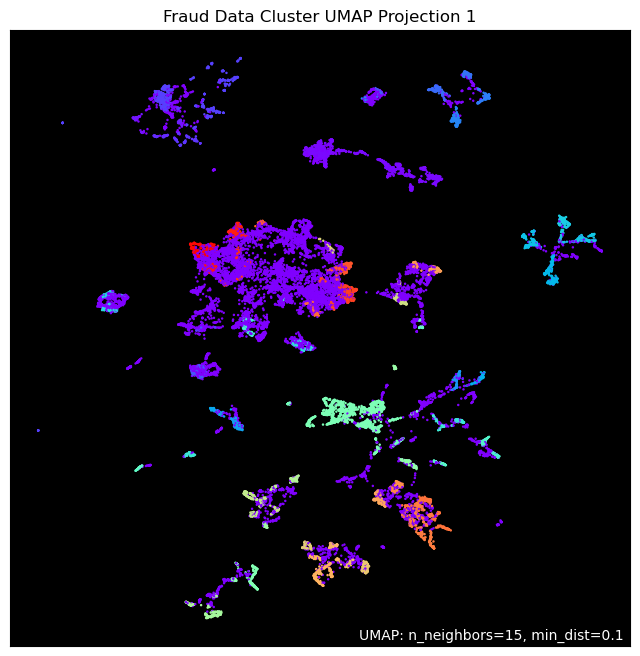

In [47]:
plot_umap_projection(hdb_df, test_hdb, param_index = 1)

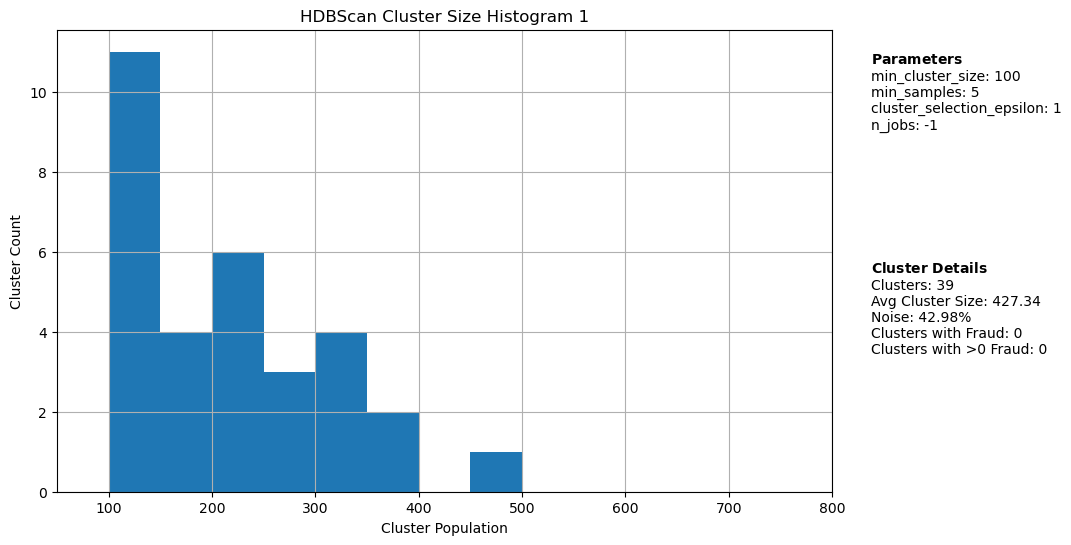

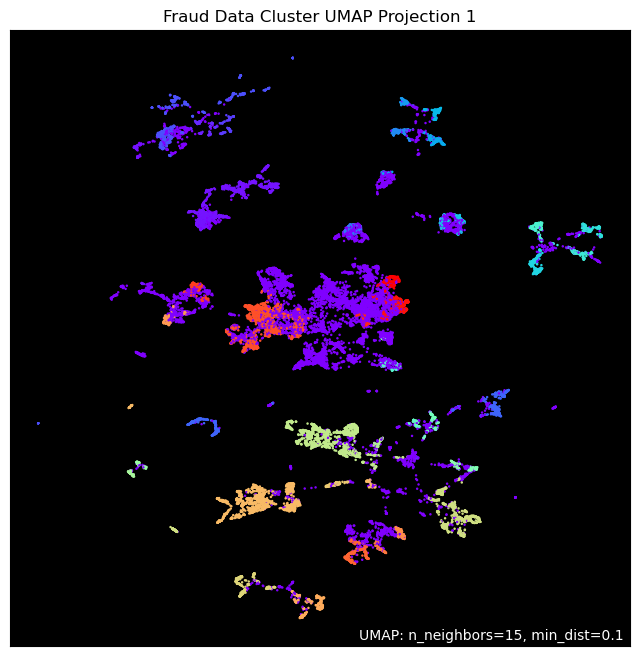

In [54]:
param_index = 1

for param in [test_param]:
    clusters = hdbscan_clustering(hdb_df, param)
    plot_cluster_histogram(label_df, clusters, test_param, param_index)
    plot_umap_projection(hdb_df, clusters, param_index)
    param_index += 1

### Applying Isolation Forest Models 

Now that we have acceptable clustering, we can attempt a more granular application of isolation forest outlier detection. 

To attempt: 
- Normal train / test split 
- Split data by day, use the more normal day to train

## Combine data with cluster labels

In [ ]:
iso_df = df.copy()

iso_df["Cluster"] = clusters

In [ ]:
from sklearn.ensemble import IsolationForest


def train_isofor(X, y, parameters):

    # Split the data into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    
    # Determine contamination rate
    contamination_rate = y_train.sum() / len(y_train) 
    params["contamination"] = contamination_rate

    # Train model 
    model = IsolationForest(**params, n_jobs = -1)
    model.fit(X_train)
    
    # Anomaly score, lower is more anomalous
    y_pred_scores = model.decision_function(X_test)  
    y_pred = model.predict(X_test)                   

    # -1 for anomaly, 1 for normal
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    
    return y_test, y_pred, params

In [ ]:
params = {"n_estimators": 100, 
          "random_state": 42} 

for c in clusters:
    
    
    

